# Exercice 3.1: Expansion planning -- Mon projet

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from linopy import Model
import pygwalker as pyg

### Loading the data

In [2]:
### Loading the data and convert to xarray DataSet

# Technologies data:
tech_param = pd.read_csv('data/technologies.csv',index_col=0)

# Storages data
sto_param = pd.read_csv("data/storage_technologies.csv", index_col=0).to_xarray()

# Dam data 
dam_param = pd.read_csv("data/dam.csv", index_col=0)

# Demand:
demand = pd.read_csv('data/demand.csv',index_col=0, sep=";").to_xarray()

# Renewable generation:
AF = {}
AF["2022"] = pd.read_csv('data/AF_2022.csv',index_col=0, sep=";") 
AF["2005"] = pd.read_csv('data/AF_2005.csv',index_col=0, sep=";")
AF["2017"] = pd.read_csv('data/AF_2017.csv',index_col=0, sep=";")
for scen in AF.keys():
    for tech in tech_param.index:
        if tech not in AF[scen].columns:
            AF[scen].loc[:,tech] = tech_param.loc[tech, "Availability"]
AF = pd.concat(AF)
AF = AF.rename_axis(["Scenarios", "Time"])
tech_param = tech_param.to_xarray()

# Dam storage
P_INFLOW = {}
P_INFLOW["2022"] = pd.read_csv('data/precipitation_2022.csv',index_col=0, sep=";") 
P_INFLOW["2005"] = pd.read_csv('data/precipitation_2005.csv',index_col=0, sep=";") 
P_INFLOW["2017"] = pd.read_csv('data/precipitation_2017.csv',index_col=0, sep=";")
P_INFLOW = pd.concat(P_INFLOW)
P_INFLOW = P_INFLOW.rename_axis(["Scenarios", "Time"])
dam_param = dam_param.to_xarray()

# Global parameters:
general_parameters = pd.read_csv('data/global_parameters.csv',index_col=0)

### Create the Sets and PARAMETERS of the linopy model

In [3]:
AF

Wind   PV
Scenarios Time                       
2022      01/01  01:00:00  0.154  0.0
          01/01  02:00:00  0.124  0.0
          01/01  03:00:00  0.102  0.0
          01/01  04:00:00  0.085  0.0
          01/01  05:00:00  0.071  0.0
...                          ...  ...
2017      12/31  20:00:00  0.335  0.0
          12/31  21:00:00  0.246  0.0
          12/31  22:00:00  0.202  0.0
          12/31  23:00:00  0.182  0.0
          12/31  24:00:00  0.160  0.0

[26280 rows x 2 columns]

In [4]:
D_max = 1
P_INFLOW*D_max

P_inflow
Scenarios Time                     
2022      01/01  01:00:00  1.485209
          01/01  02:00:00  2.184131
          01/01  03:00:00  3.118939
          01/01  04:00:00  3.948909
          01/01  05:00:00  4.141112
...                             ...
2017      12/31  20:00:00  0.698922
          12/31  21:00:00  1.048383
          12/31  22:00:00  1.537628
          12/31  23:00:00  1.939508
          12/31  24:00:00  2.131712

[26280 rows x 1 columns]

In [5]:
### Sets
Time = demand.get_index("Time")
Tech = tech_param.get_index("Technologies")
Sto = sto_param.get_index("Storages")
Scen = AF.index.get_level_values(level=0).unique()
Dam = dam_param.get_index("Dam")


# Technologies related
TECH_MAX_CAP = tech_param['Maximum capacity']
MARGINAL_FUEL_COST = tech_param['Fuel costs']/tech_param['Rated efficiency']
CO2_INTENSITY = tech_param['Fuel CO2 content']/tech_param['Rated efficiency']
TECH_PHI = tech_param["Discount rate"]/(1-(1+tech_param["Discount rate"])**(-tech_param["Lifetime"]))
TECH_IC = TECH_PHI*tech_param['Investment cost']
DELTA_MAX_UP = tech_param['Ramp-up rate']
DELTA_MAX_DOWN = tech_param['Ramp-down rate']
LEGACY = tech_param["Legacy capacity"]

AF_df = AF[Tech]
AF_df = AF_df.stack()
AF_df.index = AF_df.index.set_names("Technologies", level=2)
AF = AF_df.to_xarray()

# Dam 
P_INFLOW_df = P_INFLOW 
P_INFLOW_df = P_INFLOW_df.stack()
print(P_INFLOW_df)
P_INFLOW_df.index = P_INFLOW_df.index.set_names("Dam", level=2)
P_INFLOW = P_INFLOW["P_inflow"].to_xarray()

pi = pd.DataFrame([0.6,0.2,0.2], index=["2022","2005", "2017"], columns = ["Probability"])
PI = xr.DataArray(pi["Probability"], coords=[Scen])

# Storage related
STO_MAX_CAP = sto_param["Maximum capacity"]
STO_PHI = sto_param["Discount rate"]/(1-(1+sto_param["Discount rate"])**(-sto_param["Lifetime"]))
STO_IC = STO_PHI*sto_param["Investment cost"]
EFF_D = sto_param["Discharge efficiency"]
EFF_C = sto_param["Charge efficiency"]
SOC_MAX = sto_param["Maximum state of charge"]
SOC_MIN = sto_param["Minimum state of charge"]
STO_dT = sto_param["Storage duration"]

# DAM 
DAM_MAX_CAP = dam_param["Maximum capacity"]
DAM_PHI = dam_param["Discount rate"]/(1-(1+sto_param["Discount rate"])**(-sto_param["Lifetime"]))
DAM_IC = DAM_PHI*dam_param["Investment cost"]
SOC_MAX_DAM = dam_param["Maximum state of charge"]
SOC_MIN_DAM = dam_param["Minimum state of charge"]
EFF_DAM = dam_param["Discharge efficiency"]
DAM_dT = dam_param["Storage duration"]

# Configuration and scenario parameters
DEMAND = demand["Demand"]
DEMAND = DEMAND/1e3               # Demand [MWh/h]
TS = float(general_parameters.Value.loc['Time step'])
VOLL = float(general_parameters.Value.loc['VOLL'])
CO2_PRICE = float(general_parameters.Value.loc['CO2_price'])
CO2_BOUND = float(general_parameters.Value.loc['CO2_bound'])


Scenarios  Time                     
2022       01/01  01:00:00  P_inflow    1.485209
           01/01  02:00:00  P_inflow    2.184131
           01/01  03:00:00  P_inflow    3.118939
           01/01  04:00:00  P_inflow    3.948909
           01/01  05:00:00  P_inflow    4.141112
                                          ...   
2017       12/31  20:00:00  P_inflow    0.698922
           12/31  21:00:00  P_inflow    1.048383
           12/31  22:00:00  P_inflow    1.537628
           12/31  23:00:00  P_inflow    1.939508
           12/31  24:00:00  P_inflow    2.131712
Length: 26280, dtype: float64


### Write the optimization model (variables, constraints and objective function)

In [7]:
### Create the model instance

m = Model()

### Create the variables

cap_tech = m.add_variables(lower = 0, coords = [Tech], name = 'cap_tech') # Installed capacity of the technologies [MW]
g = m.add_variables(lower = 0, coords = [Tech, Scen, Time], name = 'g')        # Generated power [MW]
fcd = m.add_variables(lower = 0, coords = [Tech, Scen, Time], name = 'fcd')    # Fuel cost definition [EUR/h]

cap_sto = m.add_variables(lower = 0, coords = [Sto], name = 'cap_sto') # Installed capacity of the storages [MW]
sd = m.add_variables(lower = 0, coords = [Sto, Scen, Time], name = 'sd')     # Storage discharge [MW]
sc = m.add_variables(lower = 0, coords = [Sto, Scen, Time], name = 'sc')     # Storage charge [MW]
se = m.add_variables(lower = 0, coords = [Sto, Scen, Time], name = 'se')     # Stored energy [MWh]

cap_dam = m.add_variables(lower = 0, coords = [Dam], name = 'cap_dam')           # Installed capacity of the dam [MW]
sd_dam = m.add_variables(lower = 0, coords = [Dam, Scen, Time], name = 'sd_dam')     # Dam discharge [MW]
se_dam = m.add_variables(lower = 0, coords = [Dam, Scen, Time], name = 'se_dam')     # Stored energy in the dam [MWh]
p_spill = m.add_variables(lower = 0, coords = [Dam, Scen, Time], name = 'p_spill')  

co2_emissions =  m.add_variables(lower = 0, coords = [Scen], name = 'co2_emissions')     # Combined CO2 emissions [tCO2eq]
ens = m.add_variables(lower = 0, coords = [Scen, Time], name = 'ens')           # Energy no served [MWh]

curt = m.add_variables(lower = 0, coords = [Scen, Time])                      # Curtailment [MWh]

costs = m.add_variables(lower = 0, coords = [Scen])

# Create the constraints

# Technology sizing
cap_max_tech = m.add_constraints(cap_tech <= TECH_MAX_CAP, name = "cap_max_tech")
power_max = m.add_constraints(g <= AF*cap_tech, name= 'power_max')

# Ramping up/down constraints
power_rampup_initial = m.add_constraints(g.loc[:,:,:Time[0]] - g.loc[:,:,Time[len(Time)-1]:] <= DELTA_MAX_UP*cap_tech , name = 'power_rampup_initial')
power_rampup = m.add_constraints(g.loc[:,:,Time[1:]] <= g.shift(Time = 1) + DELTA_MAX_UP*cap_tech, name = 'power_rampup')

power_rampdown_initial = m.add_constraints(g.loc[:,:,:Time[0]] - g.loc[:,:,Time[len(Time)-1]:]  >= - DELTA_MAX_DOWN*cap_tech, name = 'power_rampdown_initial')
power_rampdown = m.add_constraints(g.loc[:,:,Time[1:]]>= g.shift(Time = 1) - DELTA_MAX_DOWN*cap_tech, name = 'power_rampdown')


# Storage sizing + Initial condition
cap_max_sto = m.add_constraints(cap_sto <= STO_MAX_CAP, name = "cap_max_sto")
storage_initial_state = m.add_constraints(se.loc[:,:,:Time[0]] - se.loc[:,:,Time[len(Time)-1]:]  == TS*EFF_C*sc.loc[:,:,Time[len(Time)-1]:] - TS*sd.loc[:,:,Time[len(Time)-1]:]/EFF_D, name = 'storage_initial_state')
storage_balance = m.add_constraints(se.loc[:,:,Time[1:]] - se.shift(Time = 1) == TS*EFF_C*sc.loc[:,:,Time[1:]] -TS*sd.loc[:,:,Time[1:]]/EFF_D, name = 'storage_balance')
storage_charge_max = m.add_constraints(sc <= cap_sto/STO_dT, name = 'storage_charge_max')
storage_discharge_max = m.add_constraints(sd <= cap_sto/STO_dT, name = 'storage_discharge_max')
storage_energy_max = m.add_constraints(se <= SOC_MAX*cap_sto, name = 'storage_energy_max' )
storage_energy_min = m.add_constraints(se >= SOC_MIN*cap_sto, name = 'storage_energy_min' )

# Dam sizing + Initial condition
p_inflow = P_INFLOW*cap_dam/DAM_dT
cap_max_dam = m.add_constraints(cap_dam <= DAM_MAX_CAP, name = "cap_max_dam")
dam_initial_state = m.add_constraints(se_dam.loc[:,:,:Time[0]] - se_dam.loc[:,:,Time[-1]:] ==  - TS * sd_dam.loc[:,:,Time[-1]:] - TS * p_spill.loc[:,:,Time[-1]:] + TS * p_inflow.loc[:,Time[len(Time)-1]] ,name='dam_initial_state') # 
dam_balance = m.add_constraints(se_dam.loc[:,:,Time[1:]] - se_dam.shift(Time=1) ==  - TS * sd_dam.loc[:,:,Time[1:]]/ EFF_DAM  - TS * p_spill + TS * p_inflow ,name='dam_balance') # si pompage-turbinage : TS * sc_dam.loc[:,:,Time[1:]] * EFF_C_DAM
dam_discharge_max = m.add_constraints(sd_dam <= cap_dam/DAM_dT, name = 'dam_discharge_max')
dam_energy_max = m.add_constraints(se_dam <= SOC_MAX_DAM * cap_dam, name='dam_energy_max')
dam_energy_min = m.add_constraints(se_dam >= SOC_MIN_DAM * cap_dam, name='dam_energy_min')

# Market clearing
mcc = m.add_constraints(g.sum(dims = 'Technologies') + ens + (sd - sc).sum(dims = "Storages") + sd_dam.sum(dim="Dam") == DEMAND, name = 'mcc')

# Limit on energy not served
ens_lim = m.add_constraints(ens<=DEMAND, name = 'ens_lim')

# Costs
fuel_cost = m.add_constraints(fcd == MARGINAL_FUEL_COST*g , name="fuel_cost")

# CO2 Emissions
co2_account =  m.add_constraints(co2_emissions == (CO2_INTENSITY*g).sum(dims=["Technologies", "Time"]), name="co2 account") 
co2_bound = m.add_constraints(co2_emissions <= CO2_BOUND, name = "co2_bound")

# Curtailment evaluation.
RE_MASK = xr.DataArray(np.array([1,1]), coords = [Tech])
curt_eval = m.add_constraints(curt == ((AF*cap_tech-g)*RE_MASK).sum(dims = 'Technologies') , name = 'curt')

cost_scenarios = m.add_constraints(costs == (TECH_IC*cap_tech).sum(dim="Technologies") + (STO_IC*cap_sto).sum(dim="Storages") + (DAM_IC*cap_dam).sum(dim="Dam") + 
                                              ((TS*fcd).sum(dims = ['Technologies', 'Time']) + (VOLL*TS*ens).sum(dims ='Time') + co2_emissions*CO2_PRICE))

# Add the objective function
total_cost = ((TECH_IC*cap_tech).sum(dim="Technologies") + (STO_IC*cap_sto).sum(dim="Storages") + (DAM_IC*cap_dam).sum(dim="Dam") + 
              (PI*((TS*fcd).sum(dims = ['Technologies', 'Time']) + 
                   (VOLL*TS*ens).sum(dims ='Time') + co2_emissions*CO2_PRICE)).sum(dim="Scenarios")) 

m.add_objective(total_cost)

In [8]:
p_inflow

LinearExpression (Scenarios: 3, Time: 8760, Dam: 1):
----------------------------------------------------
[2022,  01/01  01:00:00, Hydro]: +0.07426 cap_dam[Hydro]
[2022,  01/01  02:00:00, Hydro]: +0.1092 cap_dam[Hydro]
[2022,  01/01  03:00:00, Hydro]: +0.1559 cap_dam[Hydro]
[2022,  01/01  04:00:00, Hydro]: +0.1974 cap_dam[Hydro]
[2022,  01/01  05:00:00, Hydro]: +0.2071 cap_dam[Hydro]
[2022,  01/01  06:00:00, Hydro]: +0.2119 cap_dam[Hydro]
[2022,  01/01  07:00:00, Hydro]: +0.1944 cap_dam[Hydro]
		...
[2017,  12/31  18:00:00, Hydro]: +0.01747 cap_dam[Hydro]
[2017,  12/31  19:00:00, Hydro]: +0.02228 cap_dam[Hydro]
[2017,  12/31  20:00:00, Hydro]: +0.03495 cap_dam[Hydro]
[2017,  12/31  21:00:00, Hydro]: +0.05242 cap_dam[Hydro]
[2017,  12/31  22:00:00, Hydro]: +0.07688 cap_dam[Hydro]
[2017,  12/31  23:00:00, Hydro]: +0.09698 cap_dam[Hydro]
[2017,  12/31  24:00:00, Hydro]: +0.1066 cap_dam[Hydro]

### Solve

In [9]:
m.solve("gurobi")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2551043
Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be


Writing continuous variables.: 100%|██████████| 15/15 [00:00<00:00, 32.95it/s]


Read LP format model from file /tmp/linopy-problem-1s3cegyd.lp
Reading time = 0.94 seconds
obj: 525628 rows, 315370 columns, 1410833 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Gold 6354 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be
Optimize a model with 525628 rows, 315370 columns and 1410833 nonzeros
Model fingerprint: 0x940972ec
Coefficient statistics:
  Matrix range     [4e-04, 1e+08]
  Objective range  [2e-01, 6e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+04]
Presolve removed 196587 rows and 143566 columns
Presolve time: 2.05s
Presolved: 136481 rows, 385245 columns, 1178903 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.08s

Barrier statistic

('ok', 'optimal')

## Post-process

In [10]:
m.objective.value/DEMAND.sum().values

106.60431791216723

In [12]:
for scenario in Scen:
    print("Scenario : ", scenario)
    print(f"g = {g.sel(Scenarios=scenario).solution.sum().item() / 1000:.3f} GW")
    print(f"Ens = { ens.sel(Scenarios=scenario).solution.sum().values/1000:.3f} GW")
    print(f"Curt = {curt.sel(Scenarios=scenario).solution.sum().values/1000:.3f} GW")
    print(f"sd = {sd.sel(Scenarios=scenario).solution.sum().values/1000:.3f} GW")
    print(f"sd_dam = {sd_dam.sel(Scenarios=scenario).solution.sum().values/1000:.3f} GW")
    print(f"P inflow = { p_inflow.sel(Scenarios=scenario).solution.sum().values/1000:.3f} GW")
    print(f"P spill = { p_spill.sel(Scenarios=scenario).solution.sum().values/1000:.3f} GW")

    print("\n")
    print(f"DEMAND = { DEMAND.sum().values/1000:.3f} GW")
    print((g.sel(Scenarios=scenario).solution.sum().values + ens.sel(Scenarios=scenario).solution.sum().values + (sd_dam.sel(Scenarios=scenario).solution.sum().values )))#- export_grid

    print("\n")
    print(f"cap wind = { cap_tech.solution.values[0]:.3f} MW")
    print(f"cap PV = {cap_tech.solution.values[1]:.3f} MW ")
    print("energy storage battery = ", cap_sto.solution.values[0])
    print("energy dam = ", cap_dam.solution.values[0])
    print("---------------------------")


Scenario :  2022
g = 25.056 GW
Ens = 0.000 GW
Curt = 54.895 GW
sd = 3.203 GW
sd_dam = 7.785 GW
P inflow = 30.660 GW
P spill = 20.282 GW


DEMAND = 31.610 GW
32840.48404575874


cap wind = 31.964 MW
cap PV = 17.441 MW 
energy storage battery =  12.0
energy dam =  100.0
---------------------------
Scenario :  2005
g = 30.640 GW
Ens = 0.000 GW
Curt = 54.465 GW
sd = 2.967 GW
sd_dam = 2.116 GW
P inflow = 7.411 GW
P spill = 4.596 GW


DEMAND = 31.610 GW
32756.715088982677


cap wind = 31.964 MW
cap PV = 17.441 MW 
energy storage battery =  12.0
energy dam =  100.0
---------------------------
Scenario :  2017
g = 23.121 GW
Ens = 0.000 GW
Curt = 49.893 GW
sd = 3.180 GW
sd_dam = 9.713 GW
P inflow = 60.646 GW
P spill = 47.703 GW


DEMAND = 31.610 GW
32834.78514322828


cap wind = 31.964 MW
cap PV = 17.441 MW 
energy storage battery =  12.0
energy dam =  100.0
---------------------------


In [13]:
generation_df = m.solution.to_dataframe().reset_index()
pyg.walk(generation_df)

Box(children=(HTML(value='<div id="ifr-pyg-000635f061b157c5uVgqk3ZFaQ1wReIi" style="height: auto">\n    <head>…

/tmp/ipykernel_4066077/1577786959.py:6: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  total_generation_all = generation_df_all.groupby(level=1, axis=0).sum().sum()


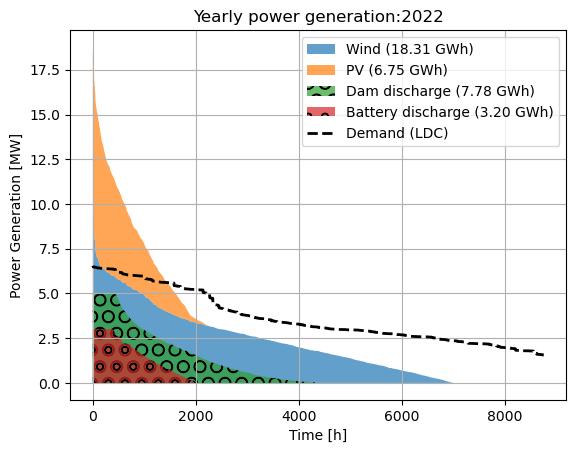

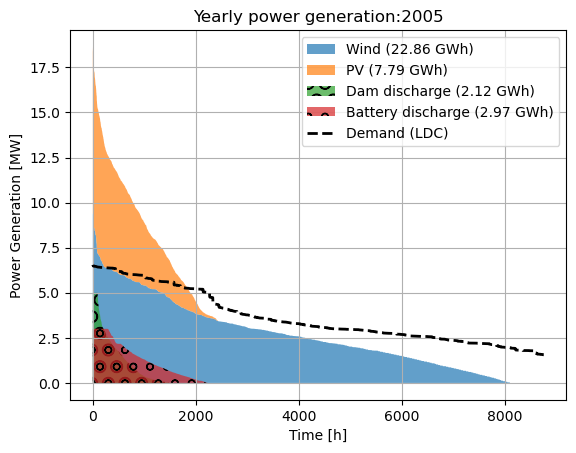

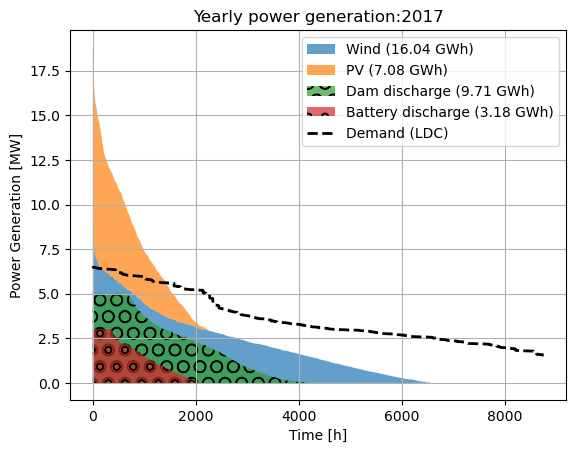

Power installed of wind :  31.96 MW
Power installed of PV : 17.44 MW
Maximum energy in the battery : 12.00 MWh
Maximum energy in the dam : 100.00 MWh


In [14]:
import matplotlib.pyplot as plt
generation_df_all = g.solution.to_dataframe().unstack(level=0)
generation_df_all.columns = generation_df_all.columns.droplevel(0)  # enlever "solution"

# Somme totale par techno, tous scénarios confondus
total_generation_all = generation_df_all.groupby(level=1, axis=0).sum().sum()

# Tri décroissant des technologies par énergie produite totale
fixed_order = total_generation_all.sort_values(ascending=False).index.tolist()

for scenario in Scen:
    plt.figure()
    generation_df = g.solution.to_dataframe().unstack(level=0)
    generation_df = generation_df.loc[scenario]
    generation_df.columns = generation_df.columns.droplevel(0)

    #discharge_dam_df = sd_dam.solution.to_dataframe()["solution"].unstack(level=0).loc[scenario]
    #discharge_dam_df["Hydro"] = sorted(discharge_dam_df["Hydro"].values, reverse=True)
    discharge_dam_df = sd_dam.solution.to_dataframe().unstack(level=0)
    discharge_dam_df = discharge_dam_df.loc[scenario]
    discharge_dam_df.columns = discharge_dam_df.columns.droplevel(0)
    total_production_dam = discharge_dam_df.sum()
    sorted_columns_dam = total_production_dam.sort_values(ascending=False).index
    discharge_dam_df = discharge_dam_df[sorted_columns_dam].apply(lambda x: x.sort_values(ascending=False).values, axis=0)

    discharge_df = sd.solution.to_dataframe().unstack(level=0)
    discharge_df = discharge_df.loc[scenario]
    discharge_df.columns = discharge_df.columns.droplevel(0)
    total_production_sto = discharge_df.sum()
    sorted_columns_sto = total_production_sto.sort_values(ascending=False).index
    discharge_df = discharge_df[sorted_columns_sto].apply(lambda x: x.sort_values(ascending=False).values, axis=0)

    # Demand
    sorted_demand = DEMAND.values.flatten()
    sorted_demand = pd.Series(sorted_demand).sort_values(ascending=False)
    
    generation_df = generation_df.reindex(columns=fixed_order)
    generation_df = generation_df.apply(lambda x: x.sort_values(ascending=False).values, axis=0)
    
    bottom_stack = np.zeros(8760)
    for column in generation_df.columns:
        energy_gwh = generation_df[column].sum()/1000
        label_with_energy = f"{column} ({energy_gwh:.2f} GWh)"
        plt.fill_between(range(8760), bottom_stack, bottom_stack + generation_df[column],
                         label=label_with_energy, alpha=0.7)
        bottom_stack += generation_df[column]

    for column_dam in discharge_dam_df.columns:
        plt.fill_between(range(8760), np.zeros(8760), discharge_dam_df[column_dam], label=f"Dam discharge ({discharge_dam_df[column_dam].sum()/1e3:.2f} GWh)", alpha=0.7, hatch="O")

    for column_sto in discharge_df.columns:
        plt.fill_between(range(8760), np.zeros(8760), discharge_df[column_sto] , label=f"Battery discharge ({discharge_df[column_sto].sum()/1e3:.2f} GWh)", alpha=0.7, hatch="o")

    plt.plot(range(8760), sorted_demand, label="Demand (LDC)", color="black", linewidth=2, linestyle="--")
    
    plt.xlabel("Time [h]")
    plt.ylabel("Power Generation [MW]")
    plt.title("Yearly power generation:" + scenario)
    plt.legend()
    plt.grid()
    plt.savefig(f"transi_{scenario}.png", format = "png")
plt.show()

print("Power installed of wind :  %.2f MW"%  cap_tech.solution.values[0])
print("Power installed of PV : %.2f MW"% cap_tech.solution.values[1])
print("Maximum energy in the battery : %.2f MWh"% cap_sto.solution.values[0])
print("Maximum energy in the dam : %.2f MWh"% cap_dam.solution.values[0])

<Axes: xlabel='Technologies'>

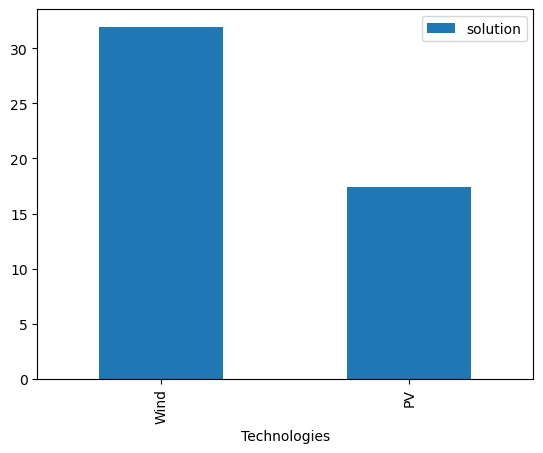

In [15]:
m.objective
cap_tech.solution.to_dataframe().plot(kind="bar")


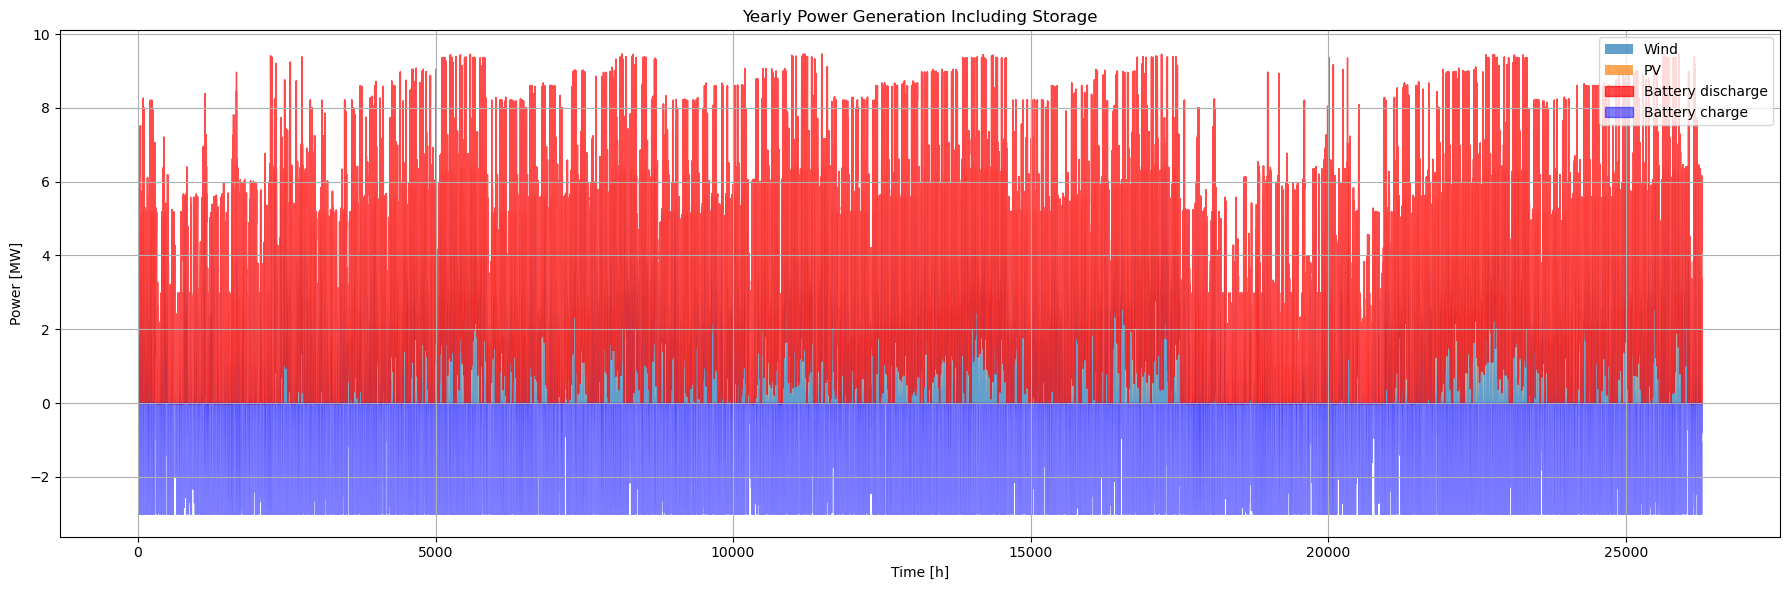

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Génération
generation_df = g.solution.to_dataframe().unstack(level=0)
generation_df.columns = generation_df.columns.droplevel(0)

# 2. Tri des colonnes
total_production = generation_df.sum()
sorted_columns = total_production.sort_values(ascending=False).index
generation_df = generation_df[sorted_columns]

# 3. Charge / décharge (alignés sur le temps)
charge_df = sc.solution.to_dataframe()["solution"].unstack(level=0).fillna(0)
discharge_df = sd.solution.to_dataframe()["solution"].unstack(level=0).fillna(0)

# 4. Addition d'une courbe empilée pour la décharge (comme source de prod)
bottom_stack = np.zeros(len(generation_df))

plt.figure(figsize=(18, 6))
for column in generation_df.columns:
    plt.fill_between(range(len(generation_df)), bottom_stack, bottom_stack + generation_df[column], label=column, alpha=0.7)
    bottom_stack += generation_df[column]

# 5. Ajouter la décharge comme "Battery discharge"
total_discharge = discharge_df.sum(axis=1)
plt.fill_between(range(len(total_discharge)), bottom_stack, bottom_stack + total_discharge, label="Battery discharge", alpha=0.7, color='red')
bottom_stack += total_discharge

# 6. Ajouter la charge (en dessous de zéro)
total_charge = charge_df.sum(axis=1)
plt.fill_between(range(len(total_charge)), 0, -total_charge, label="Battery charge", alpha=0.5, color='blue')

# 7. Plot settings
plt.xlabel("Time [h]")
plt.ylabel("Power [MW]")
plt.title("Yearly Power Generation Including Storage")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Data visualization with hvplot

In [17]:
import hvplot.xarray
import hvplot.pandas
import panel as pn
import panel.widgets as pnw

In [18]:
p1 = (-1)*sc.solution.sum(dim = "Storages")
p1 = p1.hvplot.line(x = 'Time',color = 'red', rot = 90, width = 1200, height = 1000)
p3 = sd.solution.sum(dim = "Storages").hvplot.line(x = 'Time',color = 'blue')

p2 = g.solution.hvplot.area(x = 'Time',by = 'Technologies', stacked = True, alpha = 0.5)
p4 = demand.hvplot.line(x = 'Time', color = 'black')
#p5 = (g.solution.sum(dim = 'Technologies') + GWIND + GSOLAR).rename('RE')
#p5 = p5.hvplot.area(alpha = 0.3, color = 'gold',width = 800, height = 500)
(p1*p2*p3*p4)

:DynamicMap   [Scenarios]
   :Overlay
      .Curve.I     :Curve   [Time]   (solution)
      .NdOverlay.I :NdOverlay   [Technologies]
         :Area   [Time]   (solution,Baseline)
      .Curve.II    :Curve   [Time]   (solution)
      .Curve.III   :Curve   [Time]   (Demand)

In [19]:
gen = m.solution.g.round(0).to_dataframe().reset_index()
table = pd.pivot_table(gen, values='g', index=['Time'],
                       columns=['Technologies'], aggfunc="sum")
table.hvplot.area(x = 'Time', y = table.columns.to_list(), stacked = True, alpha  = 0.4, height = 500, width = 1000)
table.hvplot(x = 'Time', kind = 'bar', stacked = True, rot = 90, width =1000, height=500, alpha  = 0.6)
#data.close()

:Bars   [Time,Technologies]   (value)